In [8]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt

img = cv2.imread('test.webp')

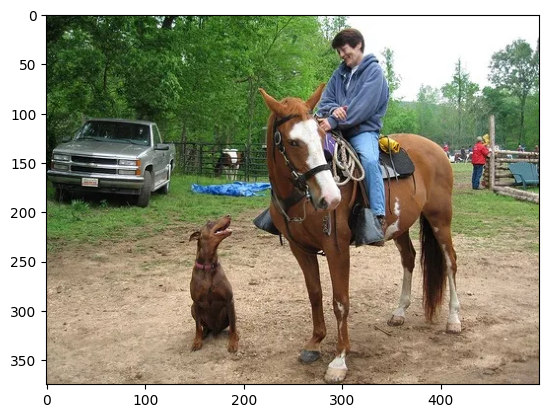

In [9]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [15]:
classes = open('coco.names').read().strip().split('\n')
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

# Give the configuration and weight files for the model and load the network.
net = cv2.dnn.readNetFromDarknet('yolov3.cfg', 'yolov3.weights')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
#net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

# Show the network object
net

< cv2.dnn.Net 0x7f489da1ffb0>

In [17]:
# First, get layer names
ln = net.getLayerNames()
len(ln)

254

In [19]:
net.getUnconnectedOutLayers()


array([200, 227, 254], dtype=int32)

In [20]:
# Show the names of this layers
try:
    print([ln[i[0] - 1] for i in net.getUnconnectedOutLayers()])
except IndexError:
    print([ln[i - 1] for i in net.getUnconnectedOutLayers()])

['yolo_82', 'yolo_94', 'yolo_106']


In [21]:
# Use this layers
try:
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

ln

['yolo_82', 'yolo_94', 'yolo_106']

Blob shape=(1, 3, 416, 416)


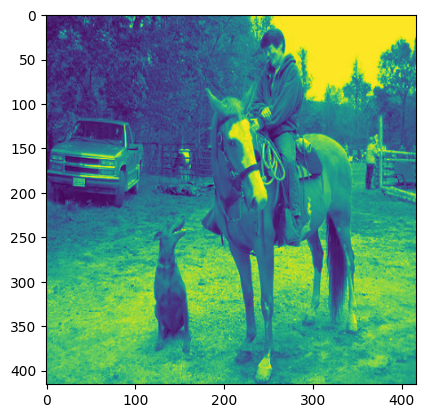

In [22]:
# Construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
r = blob[0, 0, :, :]

plt.imshow(r)
print('Blob shape=%s' % (blob.shape,))

In [23]:
net.setInput(blob)
t0 = time.time()
outputs = net.forward(ln)
t = time.time()
print('It took %.3f seconds to process the image.' % (t-t0))

It took 4.809 seconds to process the image.


In [24]:
print('Found %s objects.' % len(outputs))

print('\nEnlisting objects:')
print([out.shape for out in outputs])

Found 3 objects.

Enlisting objects:
[(507, 85), (2028, 85), (8112, 85)]


Image preview:


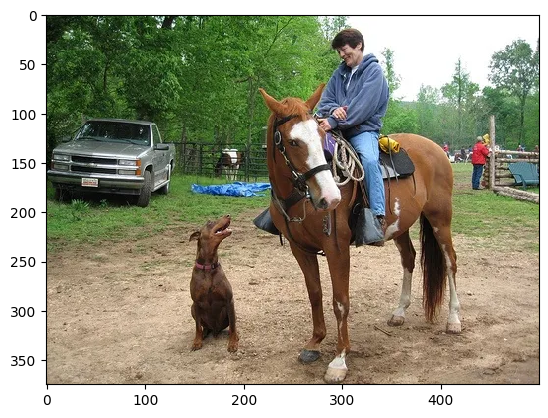

In [25]:
boxes = []
confidences = []
classIDs = []
h, w = img.shape[:2]

for output in outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.5:
            box = detection[:4] * np.array([w, h, w, h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = [x, y, int(width), int(height)]
            boxes.append(box)
            confidences.append(float(confidence))
            classIDs.append(classID)

indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
if len(indices) > 0:
    for i in indices.flatten():
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])
        color = [int(c) for c in colors[classIDs[i]]]
        
        #  -- Arguments for CV2 rectangle:
        # cv2.rect   (img,  x, y,   width, height, color, line width)
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 4)
        
        # Labels and confidences for the image
        text = "{}: {:.4f}".format(classes[classIDs[i]], confidences[i])
        cv2.putText(img, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

print('Image preview:')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')

In [26]:
cv2.imwrite('output.png', img)


True

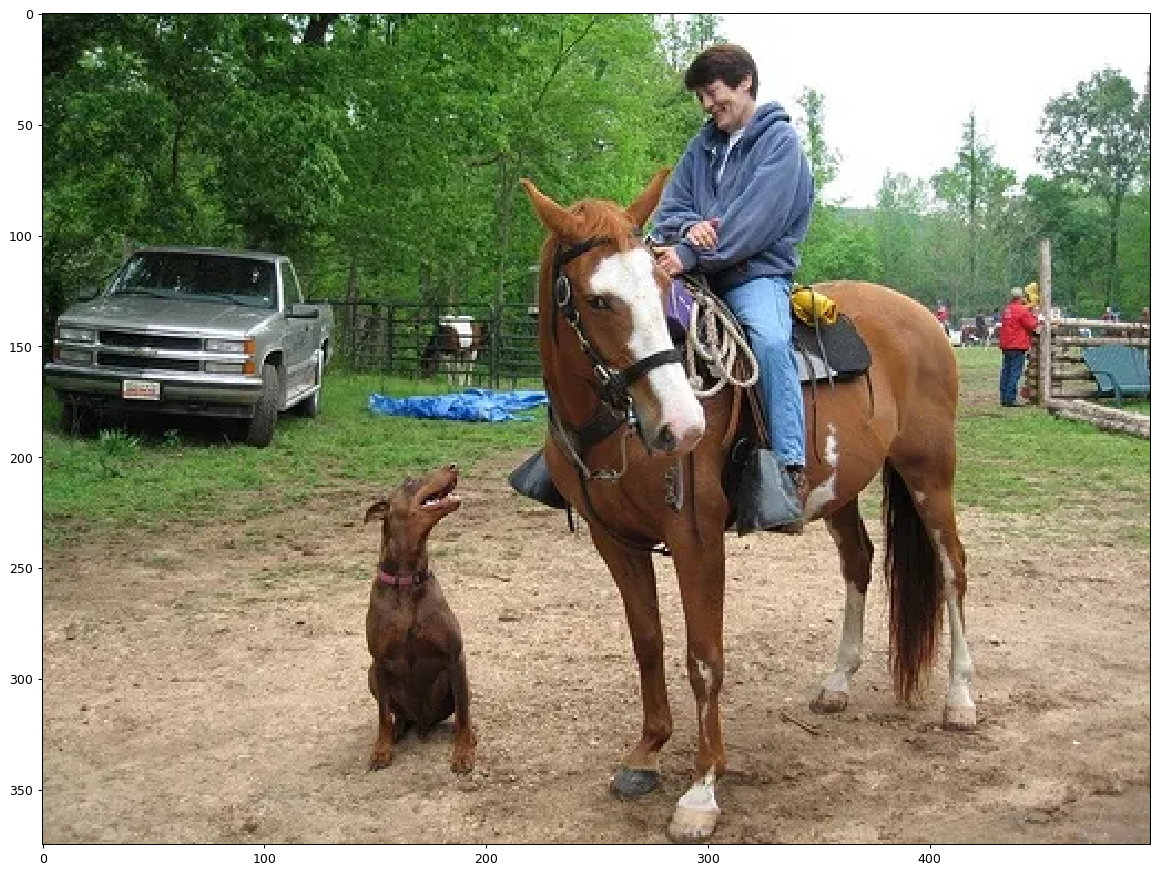

In [27]:
fig, ax = plt.subplots(figsize=(20, 12), dpi=90)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), interpolation='none')